```markdown
# Visualisation
```

In [1]:
import networkx as nx
import matplotlib.pyplot as plt
import time
import numpy as np
from model import generate_data, seq2seq_generate_tour,MambaFull, compute_tour_length
import torch
def plot_tsp(x_coord, x_path, plot_concorde=False, plot_dist_pair=False):
    """
    Helper function to plot TSP tours.
    """

    # pytorch detach
    x_coord = x_coord.detach().cpu()
    x_path = x_path.detach().cpu()
    
    # compute TSP lengths
    length_tsp = compute_tour_length(x_coord, x_path,remove_start_token=False)

    # preparation  
    x_coord = np.array(x_coord)
    x_path = np.array(x_path)
    nb_nodes = x_coord.shape[1]
    G = nx.from_numpy_array(np.zeros((nb_nodes,nb_nodes)))
    colors = ['g'] + ['b'] * (nb_nodes - 1)  # Green for 0th node, blue for others
    batch_size = x_coord.shape[0]
    max_nb_plots = 3**2 # max number of TSP plots, x^2 for x rows and x cols 
    nb_plots = batch_size if batch_size<max_nb_plots else max_nb_plots 
    nb_rows = nb_cols = int(nb_plots**0.5)
    if plot_concorde: nb_cols *= 2 # double nb of cols if concorde is plotted 
    f = plt.figure(figsize=(10, 5)) if plot_concorde else plt.figure(figsize=(15, 15)) # figure size  
    
    # gap
    running_time = 0
    gap = 0
    L_concorde = []
    
    # loop over TSPs
    for i in range(nb_plots):
        x_coord_i = x_coord[i]
        pos_i = dict(zip(range(len(x_coord_i)), x_coord_i.tolist()))
        if plot_dist_pair: # Compute pairwise distances matrix for better visualization
            dist_pair_i = squareform(pdist(x_coord_i, metric='euclidean')) 
            G = nx.from_numpy_array(dist_pair_i)
        x_path_i = x_path[i] 
        length_tsp_i = length_tsp[i]
        nodes_pair_tsp_i = []
        for r in range(nb_nodes-1): # compute consecutive nodes in the solution
            nodes_pair_tsp_i.append((x_path_i[r], x_path_i[r+1]))
        nodes_pair_tsp_i.append((x_path_i[nb_nodes-1], x_path_i[0]))
        if plot_concorde: # run concorde solver
            start = time.time()
            graph =  pd.DataFrame({'lat' : x_coord_i[:,0]}); graph['lon'] =  x_coord_i[:,1]
            solver = TSPSolver.from_data( graph.lat, graph.lon, norm="GEO" )  
            solution = solver.solve().tour
            running_time += time.time()-start
            nodes_pair_concorde_i = []
            for r in range(nb_nodes-1):
                nodes_pair_concorde_i.append((solution[r], solution[r+1]))
            nodes_pair_concorde_i.append((solution[nb_nodes-1], solution[0]))
            length_concorde = compute_tour_length(torch.tensor(x_coord_i).unsqueeze(0),torch.tensor(solution).long().unsqueeze(0))
            gap += length_tsp_i/length_concorde - 1.0
            L_concorde.append(length_concorde)
        if plot_concorde:
            subf = f.add_subplot(nb_rows,nb_cols,2*i+1)
            nx.draw_networkx_nodes(G, pos_i, node_color=colors, node_size=20)
            nx.draw_networkx_edges(G, pos_i, edgelist=nodes_pair_tsp_i, alpha=1, width=1, edge_color='r')
            if plot_dist_pair:
                nx.draw_networkx_edges(G, pos_i, alpha=0.3, width=0.5)
            subf.set_title('Length w/ NNetwork : ' + str(length_tsp_i.item())[:5])
            subf = f.add_subplot(nb_rows,nb_cols,2*i+2)
            nx.draw_networkx_nodes(G, pos_i, node_color=colors, node_size=20)
            nx.draw_networkx_edges(G, pos_i, edgelist=nodes_pair_concorde_i, alpha=1, width=1, edge_color='b') #, style='dashed'
            if plot_dist_pair:
                nx.draw_networkx_edges(G, pos_i, alpha=0.3, width=0.5)
            subf.set_title('Length w/ Concorde : ' + str(length_concorde.item())[:5])
        else:
            subf = f.add_subplot(nb_rows,nb_cols,i+1)
            nx.draw_networkx_nodes(G, pos_i, node_color=colors, node_size=20)
            nx.draw_networkx_edges(G, pos_i, edgelist=nodes_pair_tsp_i, alpha=1, width=1, edge_color='r')
            if plot_dist_pair:
                nx.draw_networkx_edges(G, pos_i, alpha=0.3, width=0.5)
            subf.set_title('Length w/ NNetwork : ' + str(length_tsp_i.item())[:5])
       

    
    # gap
    if plot_concorde:
        L_concorde = torch.stack(L_concorde).squeeze()
        print('L_concorde',L_concorde)
        print('Concorde time: {:.3f}sec'.format(running_time))  
        print('gap:',(gap/nb_plots).item())

In [2]:
coord_dim = 2
city_count = 50
test_size=2000
device = 'cuda'
test_data_loc=f'mamba/data/start_2/test_rand_{test_size}_{city_count}_{coord_dim}.pt'
#test_data = torch.load(test_data_loc).to(device)

class DotDict(dict):
    def __init__(self, **kwds):
        self.update(kwds)
        self.__dict__ = self

checkpoint = torch.load('mamba/checkpoints/big/64_G_city50_20-07_17-16.pt')
args = checkpoint['args']
model_train = MambaFull(args.d_model, args.city_count, args.nb_layers, args.coord_dim, args.mlp_cls,args.B, args.reverse,args.reverse_start,args.mamba2,args.last_layer).to(device)
model_train.load_state_dict(checkpoint['model_baseline_state_dict'])
x = generate_data(device, 4, city_count, coord_dim)[:,:-1,:] #Remove the last element which is our start token used for training
tour, _ = seq2seq_generate_tour(device,model_train,x,deterministic=True,lastlayer=args.last_layer)
plot_tsp(x,tour)

ModuleNotFoundError: No module named 'selective_scan_cuda'

In [ ]:
from benchmarks.transformer_model import TSP_net
import torch
nb_nodes = city_count # TSP100
dim_emb = 128
dim_ff = 512
dim_input_nodes = 2
nb_layers_encoder = 6
nb_layers_decoder = 2
nb_heads = 8
max_len_PE = 1000
batchnorm = True

TSP_model = TSP_net(dim_input_nodes, dim_emb, dim_ff, nb_layers_encoder, nb_layers_decoder, nb_heads, max_len_PE,batchnorm).to(device)
TSP_model.eval()
if nb_nodes == 50:
    checkpoint = torch.load('benchmarks/transformer_checkpoints/checkpoint_21-03-01--17-25-00-n50-gpu0.pt')
elif nb_nodes == 100:
    checkpoint = torch.load('benchmarks/transformer_checkpoints/checkpoint_24-06-08--18-43-26-n100-gpu0,1.pt')
epoch_ckpt = checkpoint['epoch'] + 1
tot_time_ckpt = checkpoint['tot_time']
plot_performance_train = checkpoint['plot_performance_train']
plot_performance_baseline = checkpoint['plot_performance_baseline']
TSP_model.load_state_dict(checkpoint['model_baseline'])
tour, _ = seq2seq_generate_tour(device,model_train,x,deterministic=True,lastlayer=args.last_layer)
plot_tsp(x,tour)

```markdown
# Calculate Benchmarks
```

Concorde

Problem Name: 5c12685fe9534ee8bf4c3bebebc58942
Problem Type: TSP
Number of Nodes: 100
Geographical Norm (CC_GEOGRAPHIC)
CCtsp_solve_dat ...
Finding a good tour for compression ...
linkern ...
Setting kick type to close
Starting Cycle: 1856
   0 Steps   Best: 1579   0.00 seconds
  10 Steps   Best: 1576   0.02 seconds
  50 Total Steps.
Best cycle length: 1576
Lin-Kernighan Running Time: 0.04
LK Initial Run: 1576.0
LK Run 0: 1572.0
LK Run from best tour: 1572.0
Time to find compression tour: 0.13 (seconds)
Set initial upperbound to 1572 (from tour)
Fractional Matching: 1535.0
Initial Running Time: 0.00 (seconds)
Basis Running Time: 0.00 (seconds)
Total fractional matching time: 0.00 (seconds)
Total Time for first_lp: 0.00 (seconds)
Setting upperbound to the initial bound: 1572.00
Loading lp...done in 0.00 seconds
LP has:  100 rows  154 columns  308 nonzeros
Dual opt returned after 0.00 seconds
Initial LP value: 1535.000000
Setting tolerances: next cuts 0.3700 next round 0.0370
CCtsp_init_

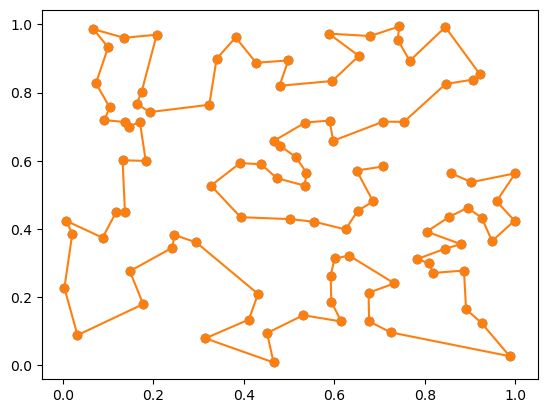

1572.0


In [2]:
from benchmarks.pyconcorde.concorde.tsp import TSPSolver
from benchmarks.pyconcorde.concorde.tests.data_utils import get_dataset_path
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
x_coord_i = np.random.rand(100,2)
plt.plot(x_coord_i[:,0],x_coord_i[:,1],'o')
graph =  pd.DataFrame({'lat' : x_coord_i[:,0]}); graph['lon'] =  x_coord_i[:,1]

# Solve the TSP problem
solver = TSPSolver.from_data(graph.lat, graph.lon, norm="GEO")
solution = solver.solve()

# Plot the tour
plt.plot(x_coord_i[solution.tour, 0], x_coord_i[solution.tour, 1], 'o-')

# Display the plot
plt.show()
print(solution.optimal_value)

Transformer

Greedy

In [6]:
from benchmarks.benchmark_solvers import greedy_tsp

NameError: name 'Greedy' is not defined